#Mount Google Drive

In [ ]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import torch

DRIVE_MOUNT = Path("/content/drive")
DRIVE_ROOT = DRIVE_MOUNT / "MyDrive" / "eye_project"
LOCAL_ROOT  = Path(r"C:\datasets\eye_project")

is_colab = False
try:
    from google.colab import drive
    drive.mount(str(DRIVE_MOUNT), force_remount=False)
    is_colab = True
    ROOT = DRIVE_ROOT
    print("Google Drive mounted at:", DRIVE_MOUNT)
except Exception as e:
    print("Google Colab drive not available or not running in Colab:", e)
    if LOCAL_ROOT.exists():
        ROOT = LOCAL_ROOT
        print("Falling back to local ROOT:", ROOT)
    else:
        ROOT = Path.cwd()
        print("Using current working directory as ROOT:", ROOT)

PROC_DIR = ROOT / "processed" / "splits_strict_10cls_new"
AUG_TRAIN_CSV = ROOT / "processed" / "train_augmented.csv"   # from your augmentation step
TRAIN_CSV      = PROC_DIR / "train.csv"
VAL_CSV        = PROC_DIR / "val.csv"
TEST_CSV       = PROC_DIR / "test.csv"
MODELS_DIR     = ROOT / "aug_models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("\nResolved paths:")
print(" ROOT        :", ROOT)
print(" PROC_DIR    :", PROC_DIR)
print(" AUG_TRAIN_CSV:", AUG_TRAIN_CSV)
print(" TRAIN_CSV   :", TRAIN_CSV)
print(" VAL_CSV     :", VAL_CSV)
print(" TEST_CSV    :", TEST_CSV)
print(" MODELS_DIR  :", MODELS_DIR)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
print("\nDevice:", DEVICE, "| Seed:", SEED)

def try_read_csv(p):
    if p.exists():
        try:
            df = pd.read_csv(p)
            print(f"\n✅ Found {p.name} — rows: {len(df):,} | columns: {list(df.columns)[:10]}")
            display(df.head(3))
            return df
        except Exception as e:
            print(f"\n⚠️ Could not read {p}: {e}")
            return None
    else:
        print(f"\n❌ Not found: {p}")
        return None

aug_df = try_read_csv(AUG_TRAIN_CSV)
if aug_df is None:
    train_df = try_read_csv(TRAIN_CSV)
else:
    train_df = aug_df

val_df = try_read_csv(VAL_CSV)
test_df = try_read_csv(TEST_CSV)

if train_df is not None and "label" in train_df.columns:
    print("\nTraining class distribution (top 20):")
    print(train_df["label"].value_counts())

print("\nIf the CSVs and paths look good, run the next cell to set transforms, dataloaders, and the VGG19 training loop (50 epochs).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at: /content/drive

Resolved paths:
 ROOT        : /content/drive/MyDrive/eye_project
 PROC_DIR    : /content/drive/MyDrive/eye_project/processed/splits_strict_10cls_new
 AUG_TRAIN_CSV: /content/drive/MyDrive/eye_project/processed/train_augmented.csv
 TRAIN_CSV   : /content/drive/MyDrive/eye_project/processed/splits_strict_10cls_new/train.csv
 VAL_CSV     : /content/drive/MyDrive/eye_project/processed/splits_strict_10cls_new/val.csv
 TEST_CSV    : /content/drive/MyDrive/eye_project/processed/splits_strict_10cls_new/test.csv
 MODELS_DIR  : /content/drive/MyDrive/eye_project/aug_models

Device: cuda | Seed: 42

✅ Found train_augmented.csv — rows: 959 | columns: ['label', 'img_path']


,label,img_path
0,DN,/content/drive/MyDrive/eye_project/processed/a...
1,DR,/content/drive/MyDrive/eye_project/processed/a...
2,ERM,/content/drive/MyDrive/eye_project/processed/a...



✅ Found val.csv — rows: 165 | columns: ['UID', 'ID', 'source', 'label', 'AION', 'ARMD', 'BRVO', 'CRVO', 'DR', 'MHL']


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_1165,1165,rfmid1_train,DR,0,0,0,0,1,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...
1,rfmid1_train_1181,1181,rfmid1_train,DR,0,0,0,0,1,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...
2,rfmid1_train_36,36,rfmid1_train,DR,0,0,0,0,1,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...



✅ Found test.csv — rows: 165 | columns: ['UID', 'ID', 'source', 'label', 'AION', 'ARMD', 'BRVO', 'CRVO', 'DR', 'MHL']


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_1804,1804,rfmid1_train,ODC,0,0,0,0,0,0,0,1,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...
1,rfmid1_train_289,289,rfmid1_train,BRVO,0,0,1,0,0,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...
2,rfmid1_train_1276,1276,rfmid1_train,DR,0,0,0,0,1,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...



Training class distribution (top 20):
label
DR      329
ODC     120
DN      111
ARMD    104
CRVO     70
BRVO     69
RPEC     54
AION     45
ERM      33
MHL      24
Name: count, dtype: int64

If the CSVs and paths look good, run the next cell to set transforms, dataloaders, and the VGG19 training loop (50 epochs).


 #Transforms, Datasets, Dataloaders, VGG19 model & 50-epoch training loop

In [ ]:
# Purpose: uses your augmented train CSV runs VGG19 for 50 epochs:
#   - Stage 1: train classifier head only for 5 epochs (lr=1e-3)
#   - Stage 2: unfreeze and train full model for 45 epochs (lr=1e-4)
import time, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision import transforms
import timm

# ---------- Config (tweakable) ----------
ROOT = Path("/content/drive/MyDrive/eye_project")
AUG_TRAIN_CSV = ROOT / "processed" / "train_augmented.csv"
VAL_CSV = ROOT / "processed" / "splits_strict_10cls_new" / "val.csv"
TEST_CSV = ROOT / "processed" / "splits_strict_10cls_new" / "test.csv"
MODELS_DIR = ROOT / "aug_models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 10
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

BATCH_SIZE = 32
INPUT_SIZE = 224
NUM_EPOCHS = 50
STAGE1_EPOCHS = 5
STAGE2_EPOCHS = NUM_EPOCHS - STAGE1_EPOCHS

LR_STAGE1 = 1e-3
LR_STAGE2 = 1e-4
WEIGHT_DECAY = 1e-2

NUM_WORKERS = 4 if torch.cuda.is_available() else 2
PIN_MEMORY = True if torch.cuda.is_available() else False

BEST_PATH = MODELS_DIR / "vgg19_best.pth"
HIST_PATH = MODELS_DIR / "vgg19_history.json"

# ---------- Transforms ----------
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ---------- Dataset ----------
class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        assert "img_path" in self.df.columns and "label" in self.df.columns, "CSV must have img_path and label"
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = Path(str(row["img_path"]))
        try:
            img = Image.open(p).convert("RGB")
        except Exception:
            # If image can't be opened, return None so collate will drop it
            return None
        if self.transform: img = self.transform(img)
        lbl = torch.tensor(CLASS_TO_IDX[row["label"]], dtype=torch.long)
        return img, lbl

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if len(batch) else (torch.empty(0), torch.empty(0, dtype=torch.long))

# ---------- Load CSVs ----------
train_df = pd.read_csv(AUG_TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

print("Train rows:", len(train_df), "| Val rows:", len(val_df), "| Test rows:", len(test_df))
print("Train class counts:\n", train_df['label'].value_counts())

train_ds = FundusDataset(train_df, transform=train_transform)
val_ds   = FundusDataset(val_df,   transform=eval_transform)
test_ds  = FundusDataset(test_df,  transform=eval_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=safe_collate)

# ---------- Class weights ----------
counts = train_df['label'].map(CLASS_TO_IDX).value_counts().sort_index()
class_counts = np.array([counts.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float32)
# Avoid zero division
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # normalize to num_classes scale
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Class counts:", class_counts)
print("Class weights:", class_weights.cpu().numpy())

# ---------- Model (VGG19) ----------
model = timm.create_model("vgg19", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)
print(model)

# Helper: compute metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    ys_true, ys_pred = [], []
    total_samples = 0

    if train:
        for xb, yb in dl:
            if xb.nelement() == 0:
                continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(1).detach().cpu().numpy()
            ys_pred.append(preds)
            ys_true.append(yb.detach().cpu().numpy())
            total_samples += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0:
                    continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)

                total_loss += loss.item() * xb.size(0)
                preds = out.argmax(1).cpu().numpy()
                ys_pred.append(preds)
                ys_true.append(yb.cpu().numpy())
                total_samples += xb.size(0)

    if total_samples == 0:
        return float('nan'), float('nan'), {}
    ys_true = np.concatenate(ys_true)
    ys_pred = np.concatenate(ys_pred)
    acc = accuracy_score(ys_true, ys_pred)
    macro_f1 = f1_score(ys_true, ys_pred, average='macro', zero_division=0)
    return (total_loss / total_samples, acc, {"macro_f1": macro_f1})

# ---------- Stage 1: freeze backbone, train head ----------
# Freeze everything except classifier layers
for name, p in model.named_parameters():
    if "classifier" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

# Setup optimizer and scheduler for stage1 (only params with requires_grad True)
opt_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(opt_params, lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(weight=class_weights)

history = {"train_loss": [], "train_acc": [], "train_macro_f1": [],
           "val_loss": [], "val_acc": [], "val_macro_f1": [], "epoch_time_sec": []}

best_val_acc = 0.0
best_epoch = 0

t0 = time.time()
epoch_no = 0

print("\n=== START STAGE 1: head-only training for %d epochs ===" % (STAGE1_EPOCHS))
for e in range(1, STAGE1_EPOCHS + 1):
    ep_t0 = time.time()
    epoch_no += 1
    tr_loss, tr_acc, tr_stats = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc, val_stats = run_epoch(model, val_dl, optimizer, criterion, DEVICE, train=False)
    scheduler.step()  # step scheduler per epoch (CosineAnnealingWarmRestarts)
    ep_time = time.time() - ep_t0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["train_macro_f1"].append(tr_stats.get("macro_f1", 0.0))
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_stats.get("macro_f1", 0.0))
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch_no:02d}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train mF1: {tr_stats.get('macro_f1',0):.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mF1: {val_stats.get('macro_f1',0):.4f} | Epoch time: {ep_time:.1f}s")

    # Save best by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch_no
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> New best val acc. Model saved.")

# ---------- Stage 2: unfreeze all and full fine-tune ----------
print("\n=== START STAGE 2: unfreeze backbone and fine-tune for %d epochs ===" % (STAGE2_EPOCHS))
for p in model.parameters():
    p.requires_grad = True

# Recreate optimizer for full model with lower LR
optimizer = optim.AdamW(model.parameters(), lr=LR_STAGE2, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

for e in range(1, STAGE2_EPOCHS + 1):
    ep_t0 = time.time()
    epoch_no += 1
    tr_loss, tr_acc, tr_stats = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc, val_stats = run_epoch(model, val_dl, optimizer, criterion, DEVICE, train=False)
    scheduler.step()
    ep_time = time.time() - ep_t0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["train_macro_f1"].append(tr_stats.get("macro_f1", 0.0))
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_stats.get("macro_f1", 0.0))
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch_no:02d}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train mF1: {tr_stats.get('macro_f1',0):.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mF1: {val_stats.get('macro_f1',0):.4f} | Epoch time: {ep_time:.1f}s")

    # Save best by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch_no
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> New best val acc. Model saved.")

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Save history JSON
with open(HIST_PATH, "w") as f:
    json.dump(history, f, indent=2)

print("Saved best model ->", BEST_PATH)
print("Saved history ->", HIST_PATH)

# Optional: run quick test evaluation using saved best model
try:
    print("\nLoading best model for test evaluation...")
    best_state = torch.load(BEST_PATH, map_location=DEVICE)
    model.load_state_dict(best_state)
    model.eval()
    # compute test accuracy
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            if xb.nelement() == 0: continue
            xb = xb.to(DEVICE)
            out = model(xb)
            preds = out.argmax(1).cpu().numpy()
            y_pred.append(preds)
            y_true.append(yb.numpy())
    if len(y_true):
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        from sklearn.metrics import classification_report, accuracy_score
        print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
        print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0))
    else:
        print("No valid test images found (check test paths).")
except Exception as e:
    print("Test evaluation skipped due to error:", e)


Device: cuda
Train rows: 959 | Val rows: 165 | Test rows: 165
Train class counts:
 label
DR      329
ODC     120
DN      111
ARMD    104
CRVO     70
BRVO     69
RPEC     54
AION     45
ERM      33
MHL      24
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class counts: [ 45. 104.  69.  70. 329.  24.  33. 120.  54. 111.]
Class weights: [1.2958611  0.5607092  0.8451268  0.8330536  0.17724544 2.4297395
 1.7670834  0.48594797 1.0798843  0.52534914]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

ValueError: optimizer got an empty parameter list

In [ ]:
import time, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

# ---------- Safety checks ----------
assert 'model' in globals(), "Model not found in this session. Run the cell that creates the model first."
assert 'train_dl' in globals() and 'val_dl' in globals(), "Dataloaders not found. Run the cell that creates dataloaders first."

# Print param names to help debugging
print("\nModel parameter name sample (first 40):")
for i, (n, p) in enumerate(model.named_parameters()):
    if i < 40:
        print(f"  {i:02d}  {n:60}  requires_grad={p.requires_grad}")
    else:
        break

# ---------- Robustly pick "head" / "classifier" parameters ----------
param_list = list(model.named_parameters())
candidate_keywords = ['classifier', 'head', 'fc', 'linear', 'cls', 'out']
candidates = [name for name, _ in param_list if any(k in name.lower() for k in candidate_keywords)]

print("\nDetected candidate parameter names containing keywords:", candidate_keywords)
print("Matches found:", len(candidates))
if len(candidates) > 0:
    # Freeze all, then unfreeze matched params
    for name, p in param_list:
        p.requires_grad = False
    print("All parameters frozen.")
    # Unfreeze matched ones
    for name, p in param_list:
        if any(k in name.lower() for k in candidate_keywords):
            p.requires_grad = True
            print("  -> Unfreezing:", name)
else:
    # Try model.classifier attribute (common for torchvision VGG)
    if hasattr(model, "classifier"):
        print("No keyword matches — trying model.classifier attribute.")
        for name, p in param_list:
            p.requires_grad = False
        for p in model.classifier.parameters():
            p.requires_grad = True
        print("Unfroze parameters in model.classifier.")
    else:
        # Last-resort: unfreeze the last N parameter tensors
        N = 8
        print(f"No obvious head detected. Falling back to unfreezing last {N} parameter tensors.")
        for name, p in param_list:
            p.requires_grad = False
        for name, p in param_list[-N:]:
            p.requires_grad = True
            print("  -> Unfreezing (fallback):", name)

# Confirm what will be optimized
opt_params = [p for p in model.parameters() if p.requires_grad]
print(f"\nNumber of parameter groups to optimize: {len(opt_params)}")
if len(opt_params) == 0:
    raise RuntimeError("Still no parameters to optimize after fallback. Inspect model parameter names above.")

# ---------- Recreate optimizer and scheduler for Stage 1 ----------
LR_STAGE1 = 1e-3
WEIGHT_DECAY = 1e-2
optimizer = optim.AdamW(opt_params, lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # class_weights from earlier cell

# ---------- Training helper ----------
def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    ys_true, ys_pred = [], []
    total = 0
    if train:
        for xb, yb in dl:
            if xb.nelement() == 0: continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            ys_pred.append(out.argmax(1).detach().cpu().numpy())
            ys_true.append(yb.detach().cpu().numpy())
            total += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0: continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                ys_pred.append(out.argmax(1).cpu().numpy())
                ys_true.append(yb.cpu().numpy())
                total += xb.size(0)
    if total == 0:
        return float('nan'), float('nan'), {"macro_f1": 0.0}
    ys_true = np.concatenate(ys_true)
    ys_pred = np.concatenate(ys_pred)
    acc = accuracy_score(ys_true, ys_pred)
    macro_f1 = f1_score(ys_true, ys_pred, average='macro', zero_division=0)
    return (total_loss/total, acc, {"macro_f1": macro_f1})

# ---------- Stage 1: head-only training (will run Stage1_EPOCHS as before) ----------
STAGE1_EPOCHS = 5
NUM_EPOCHS = 50
LR_STAGE2 = 1e-4

history_partial = {"train_loss": [], "train_acc": [], "train_macro_f1": [],
                   "val_loss": [], "val_acc": [], "val_macro_f1": [], "epoch_time_sec": []}

best_val_acc = 0.0
best_epoch = 0
epoch_no = 0
t0 = time.time()

print("\n=== Running Stage 1 (head-only) for %d epochs ===" % STAGE1_EPOCHS)
for e in range(1, STAGE1_EPOCHS+1):
    ep_t0 = time.time()
    epoch_no += 1
    tr_loss, tr_acc, tr_stats = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc, val_stats = run_epoch(model, val_dl, optimizer, criterion, DEVICE, train=False)
    scheduler.step()
    ep_time = time.time() - ep_t0

    history_partial["train_loss"].append(tr_loss)
    history_partial["train_acc"].append(tr_acc)
    history_partial["train_macro_f1"].append(tr_stats.get("macro_f1",0.0))
    history_partial["val_loss"].append(val_loss)
    history_partial["val_acc"].append(val_acc)
    history_partial["val_macro_f1"].append(val_stats.get("macro_f1",0.0))
    history_partial["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch_no:02d}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train mF1: {tr_stats.get('macro_f1',0):.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mF1: {val_stats.get('macro_f1',0):.4f} | Time: {ep_time:.1f}s")

    # Save best by val accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch_no
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> New best val acc. Model saved.")

# ---------- Stage 2: unfreeze entire model and fine-tune ----------
print("\n=== Stage 2: unfreezing all params and fine-tuning ===")
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=LR_STAGE2, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

STAGE2_EPOCHS = NUM_EPOCHS - STAGE1_EPOCHS
for e in range(1, STAGE2_EPOCHS+1):
    ep_t0 = time.time()
    epoch_no += 1
    tr_loss, tr_acc, tr_stats = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc, val_stats = run_epoch(model, val_dl, optimizer, criterion, DEVICE, train=False)
    scheduler.step()
    ep_time = time.time() - ep_t0

    history_partial["train_loss"].append(tr_loss)
    history_partial["train_acc"].append(tr_acc)
    history_partial["train_macro_f1"].append(tr_stats.get("macro_f1",0.0))
    history_partial["val_loss"].append(val_loss)
    history_partial["val_acc"].append(val_acc)
    history_partial["val_macro_f1"].append(val_stats.get("macro_f1",0.0))
    history_partial["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch_no:02d}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train mF1: {tr_stats.get('macro_f1',0):.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mF1: {val_stats.get('macro_f1',0):.4f} | Time: {ep_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch_no
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> New best val acc. Model saved.")

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Save history (append if HIST_PATH exists)
try:
    existing = {}
    if HIST_PATH.exists():
        with open(HIST_PATH, "r") as f:
            existing = json.load(f)
except Exception:
    existing = {}

# Combine/overwrite with new history and save
with open(HIST_PATH, "w") as f:
    json.dump(history_partial, f, indent=2)
print("Saved training history to", HIST_PATH)
print("Saved best model to", BEST_PATH)



Model parameter name sample (first 40):
  00  features.0.weight                                             requires_grad=False
  01  features.0.bias                                               requires_grad=False
  02  features.2.weight                                             requires_grad=False
  03  features.2.bias                                               requires_grad=False
  04  features.5.weight                                             requires_grad=False
  05  features.5.bias                                               requires_grad=False
  06  features.7.weight                                             requires_grad=False
  07  features.7.bias                                               requires_grad=False
  08  features.10.weight                                            requires_grad=False
  09  features.10.bias                                              requires_grad=False
  10  features.12.weight                                            requires_gr

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 01/50 | Train Loss: 2.4513, Train Acc: 0.2607, Train mF1: 0.1848 | Val Loss: 2.2211, Val Acc: 0.1394, Val mF1: 0.1090 | Time: 134.7s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 02/50 | Train Loss: 1.5230, Train Acc: 0.4765, Train mF1: 0.4331 | Val Loss: 1.8437, Val Acc: 0.5515, Val mF1: 0.3267 | Time: 77.0s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 03/50 | Train Loss: 1.0169, Train Acc: 0.6246, Train mF1: 0.6054 | Val Loss: 1.9292, Val Acc: 0.6121, Val mF1: 0.3289 | Time: 77.4s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 04/50 | Train Loss: 0.6353, Train Acc: 0.7529, Train mF1: 0.7584 | Val Loss: 2.0712, Val Acc: 0.5939, Val mF1: 0.3271 | Time: 76.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 05/50 | Train Loss: 0.4473, Train Acc: 0.8092, Train mF1: 0.8315 | Val Loss: 1.8313, Val Acc: 0.5818, Val mF1: 0.3486 | Time: 62.4s

=== Stage 2: unfreezing all params and fine-tuning ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 06/50 | Train Loss: 2.0420, Train Acc: 0.3504, Train mF1: 0.3566 | Val Loss: 1.5316, Val Acc: 0.4182, Val mF1: 0.3382 | Time: 66.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 07/50 | Train Loss: 0.9425, Train Acc: 0.6131, Train mF1: 0.6192 | Val Loss: 1.4390, Val Acc: 0.5697, Val mF1: 0.4310 | Time: 67.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 08/50 | Train Loss: 0.5695, Train Acc: 0.7383, Train mF1: 0.7590 | Val Loss: 1.6938, Val Acc: 0.7394, Val mF1: 0.5174 | Time: 64.7s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 09/50 | Train Loss: 0.3204, Train Acc: 0.8332, Train mF1: 0.8610 | Val Loss: 1.9732, Val Acc: 0.7515, Val mF1: 0.5151 | Time: 81.4s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50 | Train Loss: 0.2224, Train Acc: 0.8936, Train mF1: 0.9210 | Val Loss: 1.8093, Val Acc: 0.7273, Val mF1: 0.5145 | Time: 82.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50 | Train Loss: 0.4089, Train Acc: 0.8081, Train mF1: 0.8212 | Val Loss: 1.5941, Val Acc: 0.5394, Val mF1: 0.3644 | Time: 65.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50 | Train Loss: 0.4120, Train Acc: 0.8290, Train mF1: 0.8390 | Val Loss: 2.4231, Val Acc: 0.7091, Val mF1: 0.4497 | Time: 67.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50 | Train Loss: 0.4416, Train Acc: 0.8060, Train mF1: 0.8095 | Val Loss: 1.8799, Val Acc: 0.6667, Val mF1: 0.4463 | Time: 66.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50 | Train Loss: 0.3222, Train Acc: 0.8530, Train mF1: 0.8698 | Val Loss: 2.1159, Val Acc: 0.7091, Val mF1: 0.4515 | Time: 66.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/50 | Train Loss: 0.1631, Train Acc: 0.9124, Train mF1: 0.9334 | Val Loss: 2.2632, Val Acc: 0.7455, Val mF1: 0.5331 | Time: 66.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/50 | Train Loss: 0.0803, Train Acc: 0.9572, Train mF1: 0.9652 | Val Loss: 2.9888, Val Acc: 0.7333, Val mF1: 0.5976 | Time: 66.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/50 | Train Loss: 0.0546, Train Acc: 0.9708, Train mF1: 0.9789 | Val Loss: 2.6000, Val Acc: 0.7697, Val mF1: 0.5491 | Time: 68.0s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/50 | Train Loss: 0.0323, Train Acc: 0.9885, Train mF1: 0.9896 | Val Loss: 2.7380, Val Acc: 0.7697, Val mF1: 0.5558 | Time: 83.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/50 | Train Loss: 0.0297, Train Acc: 0.9864, Train mF1: 0.9901 | Val Loss: 2.7041, Val Acc: 0.7455, Val mF1: 0.5881 | Time: 67.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/50 | Train Loss: 0.0238, Train Acc: 0.9864, Train mF1: 0.9906 | Val Loss: 2.6072, Val Acc: 0.7636, Val mF1: 0.6036 | Time: 65.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21/50 | Train Loss: 0.0855, Train Acc: 0.9718, Train mF1: 0.9723 | Val Loss: 4.0024, Val Acc: 0.6848, Val mF1: 0.5155 | Time: 67.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22/50 | Train Loss: 0.3236, Train Acc: 0.8665, Train mF1: 0.8722 | Val Loss: 2.6388, Val Acc: 0.7455, Val mF1: 0.5252 | Time: 66.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23/50 | Train Loss: 0.1927, Train Acc: 0.9020, Train mF1: 0.9214 | Val Loss: 1.9410, Val Acc: 0.7273, Val mF1: 0.5974 | Time: 66.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24/50 | Train Loss: 0.2217, Train Acc: 0.9093, Train mF1: 0.9165 | Val Loss: 1.7512, Val Acc: 0.7394, Val mF1: 0.5424 | Time: 68.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25/50 | Train Loss: 0.1771, Train Acc: 0.9281, Train mF1: 0.9313 | Val Loss: 2.7568, Val Acc: 0.7455, Val mF1: 0.5786 | Time: 68.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26/50 | Train Loss: 0.1460, Train Acc: 0.9281, Train mF1: 0.9345 | Val Loss: 2.3991, Val Acc: 0.6848, Val mF1: 0.4703 | Time: 66.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27/50 | Train Loss: 0.0406, Train Acc: 0.9771, Train mF1: 0.9852 | Val Loss: 2.7722, Val Acc: 0.7273, Val mF1: 0.5476 | Time: 67.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28/50 | Train Loss: 0.0247, Train Acc: 0.9739, Train mF1: 0.9819 | Val Loss: 4.5664, Val Acc: 0.6970, Val mF1: 0.5484 | Time: 66.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29/50 | Train Loss: 0.0435, Train Acc: 0.9677, Train mF1: 0.9811 | Val Loss: 2.2357, Val Acc: 0.7939, Val mF1: 0.6144 | Time: 68.0s
  -> New best val acc. Model saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30/50 | Train Loss: 0.0106, Train Acc: 0.9937, Train mF1: 0.9962 | Val Loss: 3.0911, Val Acc: 0.7515, Val mF1: 0.5902 | Time: 82.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31/50 | Train Loss: 0.0061, Train Acc: 0.9958, Train mF1: 0.9973 | Val Loss: 3.5354, Val Acc: 0.7697, Val mF1: 0.6014 | Time: 67.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32/50 | Train Loss: 0.0093, Train Acc: 0.9917, Train mF1: 0.9933 | Val Loss: 3.0680, Val Acc: 0.7576, Val mF1: 0.5852 | Time: 66.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33/50 | Train Loss: 0.0082, Train Acc: 0.9948, Train mF1: 0.9963 | Val Loss: 3.2953, Val Acc: 0.7576, Val mF1: 0.5919 | Time: 65.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34/50 | Train Loss: 0.0029, Train Acc: 0.9969, Train mF1: 0.9982 | Val Loss: 3.4692, Val Acc: 0.7455, Val mF1: 0.5833 | Time: 66.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35/50 | Train Loss: 0.0014, Train Acc: 1.0000, Train mF1: 1.0000 | Val Loss: 3.5999, Val Acc: 0.7394, Val mF1: 0.5879 | Time: 66.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36/50 | Train Loss: 0.0044, Train Acc: 0.9979, Train mF1: 0.9985 | Val Loss: 3.7529, Val Acc: 0.7576, Val mF1: 0.6005 | Time: 67.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37/50 | Train Loss: 0.0016, Train Acc: 1.0000, Train mF1: 1.0000 | Val Loss: 3.7427, Val Acc: 0.7576, Val mF1: 0.5902 | Time: 66.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38/50 | Train Loss: 0.0015, Train Acc: 0.9990, Train mF1: 0.9994 | Val Loss: 3.6340, Val Acc: 0.7576, Val mF1: 0.5918 | Time: 66.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39/50 | Train Loss: 0.0015, Train Acc: 1.0000, Train mF1: 1.0000 | Val Loss: 3.6191, Val Acc: 0.7576, Val mF1: 0.5883 | Time: 66.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40/50 | Train Loss: 0.0012, Train Acc: 1.0000, Train mF1: 1.0000 | Val Loss: 3.6238, Val Acc: 0.7576, Val mF1: 0.5883 | Time: 65.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41/50 | Train Loss: 0.0045, Train Acc: 0.9969, Train mF1: 0.9974 | Val Loss: 3.5370, Val Acc: 0.7576, Val mF1: 0.5784 | Time: 67.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42/50 | Train Loss: 0.0190, Train Acc: 0.9864, Train mF1: 0.9902 | Val Loss: 2.9132, Val Acc: 0.7879, Val mF1: 0.6056 | Time: 66.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43/50 | Train Loss: 0.0176, Train Acc: 0.9906, Train mF1: 0.9927 | Val Loss: 4.1125, Val Acc: 0.7697, Val mF1: 0.6167 | Time: 70.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44/50 | Train Loss: 0.5383, Train Acc: 0.7998, Train mF1: 0.8022 | Val Loss: 2.0238, Val Acc: 0.6970, Val mF1: 0.5260 | Time: 67.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45/50 | Train Loss: 0.3666, Train Acc: 0.8332, Train mF1: 0.8330 | Val Loss: 2.4242, Val Acc: 0.6727, Val mF1: 0.4135 | Time: 77.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46/50 | Train Loss: 0.4794, Train Acc: 0.8102, Train mF1: 0.8237 | Val Loss: 1.7480, Val Acc: 0.6848, Val mF1: 0.4523 | Time: 69.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47/50 | Train Loss: 0.1990, Train Acc: 0.8874, Train mF1: 0.9082 | Val Loss: 2.1664, Val Acc: 0.7939, Val mF1: 0.6238 | Time: 67.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48/50 | Train Loss: 0.0863, Train Acc: 0.9562, Train mF1: 0.9670 | Val Loss: 2.2832, Val Acc: 0.6667, Val mF1: 0.5287 | Time: 69.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49/50 | Train Loss: 0.1406, Train Acc: 0.9208, Train mF1: 0.9401 | Val Loss: 2.7437, Val Acc: 0.7455, Val mF1: 0.5290 | Time: 66.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50/50 | Train Loss: 0.0574, Train Acc: 0.9760, Train mF1: 0.9825 | Val Loss: 2.9574, Val Acc: 0.7879, Val mF1: 0.6113 | Time: 68.1s

Training finished in 59.14 min
Best validation accuracy: 0.7939 at epoch 29
Saved training history to /content/drive/MyDrive/eye_project/aug_models/vgg19_history.json
Saved best model to /content/drive/MyDrive/eye_project/aug_models/vgg19_best.pth


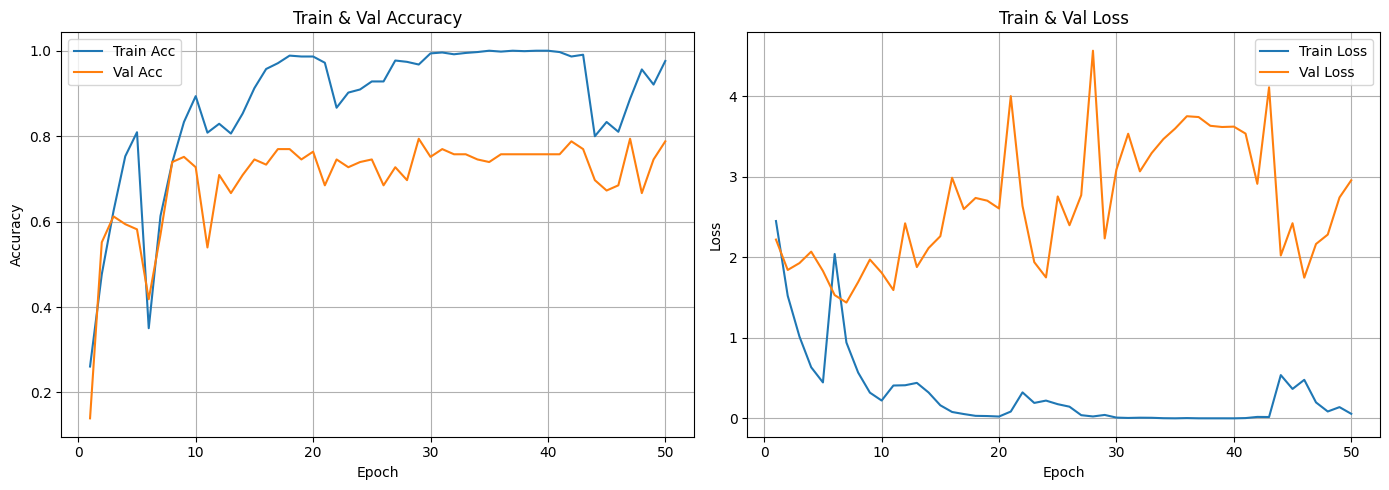

Saved curves to: /content/drive/MyDrive/eye_project/aug_models/eval/aug/train_val_curves_aug.png


In [ ]:
# ---------- Train/Val curves ----------
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/eye_project")
HIST_JSON = ROOT / "aug_models" / "vgg19_history.json"
OUT_DIR = ROOT / "aug_models" / "eval" / "aug"
OUT_DIR.mkdir(parents=True, exist_ok=True)

if not HIST_JSON.exists():
    print("History JSON not found:", HIST_JSON)
else:
    with open(HIST_JSON,"r") as f:
        hist = json.load(f)
    epochs = range(1, len(hist.get("train_loss",[]))+1)
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, hist.get("train_acc",[]), label="Train Acc")
    plt.plot(epochs, hist.get("val_acc",[]), label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Train & Val Accuracy")
    plt.legend(); plt.grid()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, hist.get("train_loss",[]), label="Train Loss")
    plt.plot(epochs, hist.get("val_loss",[]), label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train & Val Loss")
    plt.legend(); plt.grid()
    plt.tight_layout()
    p = OUT_DIR / "train_val_curves_aug.png"
    plt.savefig(p, dpi=200); plt.show()
    print("Saved curves to:", p)


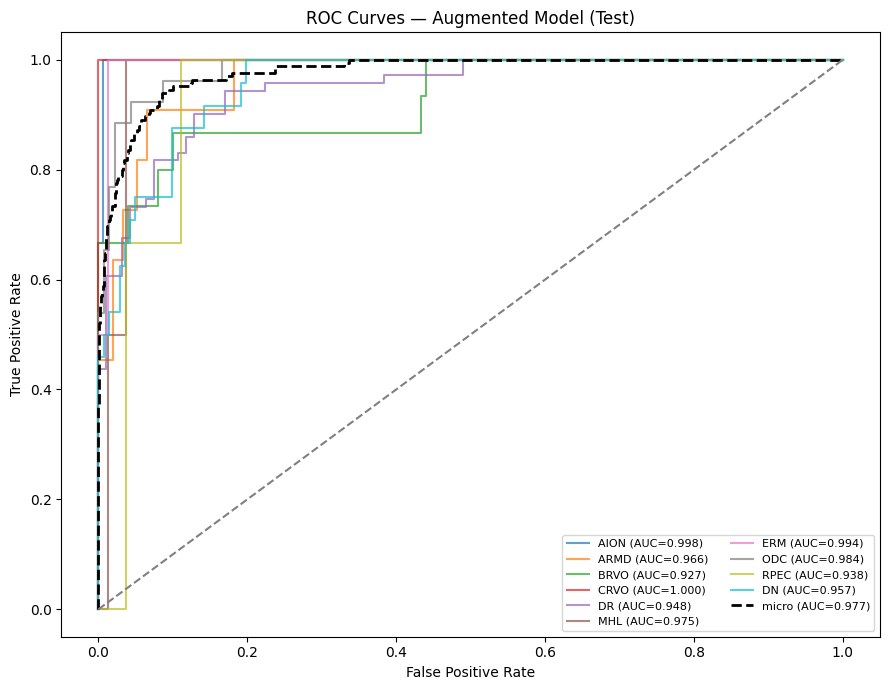

Saved ROC plot to: /content/drive/MyDrive/eye_project/aug_models/eval/aug/roc_curves_aug.png


In [ ]:
# ----------Multi-class ROC curves (one-vs-rest + micro) ----------
import numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
import timm
from torch.utils.data import Dataset
import pandas as pd

ROOT = Path("/content/drive/MyDrive/eye_project")
BEST_PATH = ROOT / "aug_models" / "vgg19_best.pth"
TEST_CSV = ROOT / "processed" / "splits_strict_10cls_new" / "test.csv"
OUT_DIR = ROOT / "aug_models" / "eval" / "aug"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 if DEVICE=="cpu" else 32

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
df = pd.read_csv(TEST_CSV).reset_index(drop=True)
class TestDS(Dataset):
    def __init__(self, df, transform):
        self.df = df; self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = Path(str(row["img_path"]))
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = CLASSES.index(row["label"])
        return img, lbl

test_ds = TestDS(df, transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# load model
model = timm.create_model("vgg19", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state); model.to(DEVICE); model.eval()

# collect probs and labels
all_probs, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs); all_labels.append(yb.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
y_onehot = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))

fpr = {}; tpr = {}; roc_auc = {}
plt.figure(figsize=(9,7))
for i in range(NUM_CLASSES):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{CLASSES[i]} (AUC={roc_auc[i]:.3f})", alpha=0.7)
    except Exception as e:
        print("ROC skipped for", CLASSES[i], e)
# micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="black", linewidth=2, label=f"micro (AUC={roc_auc['micro']:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Augmented Model (Test)")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
p = OUT_DIR / "roc_curves_aug.png"
plt.savefig(p, dpi=200); plt.show()
print("Saved ROC plot to:", p)


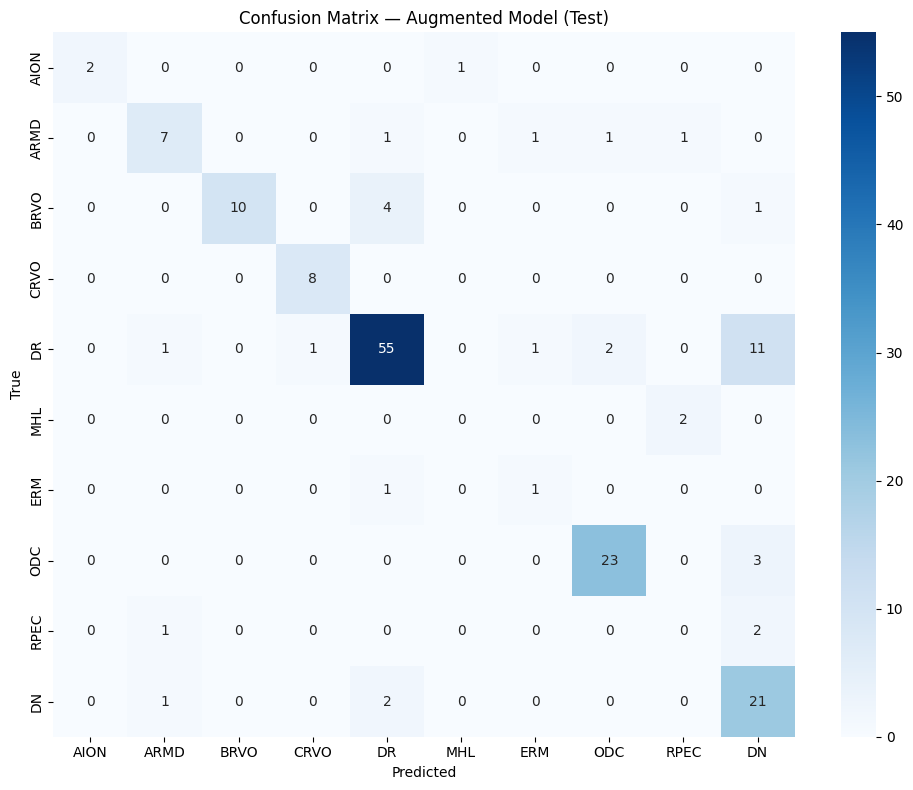

Saved confusion matrix to: /content/drive/MyDrive/eye_project/aug_models/eval/aug/confusion_matrix_aug.png

Classification Report:

              precision    recall  f1-score   support

        AION       1.00      0.67      0.80         3
        ARMD       0.70      0.64      0.67        11
        BRVO       1.00      0.67      0.80        15
        CRVO       0.89      1.00      0.94         8
          DR       0.87      0.77      0.82        71
         MHL       0.00      0.00      0.00         2
         ERM       0.33      0.50      0.40         2
         ODC       0.88      0.88      0.88        26
        RPEC       0.00      0.00      0.00         3
          DN       0.55      0.88      0.68        24

    accuracy                           0.77       165
   macro avg       0.62      0.60      0.60       165
weighted avg       0.80      0.77      0.77       165

Saved classification report JSON to: /content/drive/MyDrive/eye_project/aug_models/eval/aug/classification_re

In [ ]:
# ---------- Cell A: Confusion matrix + classification report ----------
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

# Config
ROOT = Path("/content/drive/MyDrive/eye_project")
BEST_PATH = ROOT / "aug_models" / "vgg19_best.pth"
TEST_CSV = ROOT / "processed" / "splits_strict_10cls_new" / "test.csv"
OUT_DIR = ROOT / "aug_models" / "eval" / "aug"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

# Safety checks
assert BEST_PATH.exists(), f"Model not found: {BEST_PATH}"
assert TEST_CSV.exists(), f"Test CSV not found: {TEST_CSV}"

# Device & dataloader
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 if DEVICE=="cpu" else 32

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

import pandas as pd
df = pd.read_csv(TEST_CSV).reset_index(drop=True)
class TestDS(Dataset):
    def __init__(self, df, transform):
        self.df = df; self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = Path(str(row["img_path"]))
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = CLASSES.index(row["label"])
        return img, lbl

test_ds = TestDS(df, transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load model
model = timm.create_model("vgg19", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state); model.to(DEVICE); model.eval()

# Collect preds
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix — Augmented Model (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
p = OUT_DIR / "confusion_matrix_aug.png"
plt.savefig(p, dpi=200); plt.show()
print("Saved confusion matrix to:", p)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0))

# Also save JSON report
p_vals, r_vals, f_vals, sup = precision_recall_fscore_support(y_true, y_pred, labels=list(range(NUM_CLASSES)), zero_division=0)
report = {CLASSES[i]: {"precision":float(p_vals[i]), "recall":float(r_vals[i]), "f1":float(f_vals[i]), "support":int(sup[i])} for i in range(NUM_CLASSES)}
report["accuracy"] = float((y_true==y_pred).mean())
with open(OUT_DIR/"classification_report_aug.json","w") as f:
    json.dump(report, f, indent=2)
print("Saved classification report JSON to:", OUT_DIR/"classification_report_aug.json")
